In [1]:
# Install required libraries
!pip install datasets transformers evaluate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.8 MB/s eta 0:00:00


In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW, get_scheduler
from datasets import load_dataset
from sklearn.model_selection import KFold
from evaluate import load

In [3]:
# Initialize tokenizer and model
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

In [ ]:
# Load dataset from Hugging Face
data = load_dataset("", split="train")

README.md:   0%|          | 0.00/357 [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/251M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/251M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/19455 [00:00<?, ? examples/s]

In [5]:
# Define custom Dataset class
class FindingsDataset(Dataset):
    def __init__(self, data, tokenizer, max_input_length=512, max_target_length=256):
        self.data = data
        self.tokenizer = tokenizer
        self.max_input_length = max_input_length
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        finding = self.data[idx]['findings']
        impression = self.data[idx]['impression']

        inputs = self.tokenizer(
            finding, 
            max_length=self.max_input_length, 
            truncation=True, 
            padding='max_length', 
            return_tensors="pt"
        )
        targets = self.tokenizer(
            impression, 
            max_length=self.max_target_length, 
            truncation=True, 
            padding='max_length', 
            return_tensors="pt"
        )

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'labels': targets['input_ids'].squeeze(0),
        }

In [7]:
# Define hyperparameters
batch_size = 8
learning_rate = 5e-5
epochs = 3
num_folds = 5

In [8]:
# Prepare k-fold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)
data_list = data.to_pandas().to_dict('records')  # Convert dataset to list of dicts for compatibility

In [9]:
# Training loop with k-fold
for fold, (train_idx, val_idx) in enumerate(kf.split(data_list)):
    print(f"\n[Fold {fold+1}/{num_folds}]")
    train_data = [data_list[i] for i in train_idx]
    val_data = [data_list[i] for i in val_idx]

    train_dataset = FindingsDataset(train_data, tokenizer)
    val_dataset = FindingsDataset(val_data, tokenizer)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    optimizer = AdamW(model.parameters(), lr=learning_rate)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)

    for epoch in range(epochs):
        # Training phase
        model.train()
        train_loss = 0
        for batch in train_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            loss = outputs.loss
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss = 0
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            with torch.no_grad():
                outputs = model(**batch)
            val_loss += outputs.loss.item()

        val_loss /= len(val_loader)
        print(f"Epoch {epoch+1} | Validation Loss: {val_loss:.4f}")


[Fold 1/5]


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 | Train Loss: 0.3175
Epoch 1 | Validation Loss: 0.1267
Epoch 2 | Train Loss: 0.1236
Epoch 2 | Validation Loss: 0.1185
Epoch 3 | Train Loss: 0.1096
Epoch 3 | Validation Loss: 0.1146

[Fold 2/5]
Epoch 1 | Train Loss: 0.1056
Epoch 1 | Validation Loss: 0.0900
Epoch 2 | Train Loss: 0.0948
Epoch 2 | Validation Loss: 0.0910
Epoch 3 | Train Loss: 0.0854
Epoch 3 | Validation Loss: 0.0927

[Fold 3/5]
Epoch 1 | Train Loss: 0.0838
Epoch 1 | Validation Loss: 0.0670
Epoch 2 | Train Loss: 0.0751
Epoch 2 | Validation Loss: 0.0702
Epoch 3 | Train Loss: 0.0678
Epoch 3 | Validation Loss: 0.0732

[Fold 4/5]
Epoch 1 | Train Loss: 0.0672
Epoch 1 | Validation Loss: 0.0470
Epoch 2 | Train Loss: 0.0592
Epoch 2 | Validation Loss: 0.0495
Epoch 3 | Train Loss: 0.0516
Epoch 3 | Validation Loss: 0.0515

[Fold 5/5]
Epoch 1 | Train Loss: 0.0518
Epoch 1 | Validation Loss: 0.0295
Epoch 2 | Train Loss: 0.0446
Epoch 2 | Validation Loss: 0.0316
Epoch 3 | Train Loss: 0.0384
Epoch 3 | Validation Loss: 0.0348


In [ ]:
from evaluate import load

# Load metrics
bleu_metric = load("bleu")
rouge_metric = load("rouge")

# Function to evaluate the model on a dataset
def evaluate_model(model, tokenizer, dataloader, device):
    model.eval()
    predictions = []
    references = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']

            outputs = model.generate(input_ids=input_ids, attention_mask=attention_mask, max_length=256)
            preds = tokenizer.batch_decode(outputs, skip_special_tokens=True)
            refs = tokenizer.batch_decode(labels, skip_special_tokens=True)

            predictions.extend(preds)
            references.extend(refs)

    # Evaluate BLEU
    bleu = bleu_metric.compute(predictions=predictions, references=[[ref] for ref in references])
    # Evaluate ROUGE
    rouge = rouge_metric.compute(predictions=predictions, references=references)

    return bleu, rouge

# Prepare the test set
test_data = load_dataset("", split="test")
test_dataset = FindingsDataset(test_data, tokenizer)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Evaluate the model on the test set
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

bleu_score, rouge_scores = evaluate_model(model, tokenizer, test_loader, device)

# Print evaluation metrics
print("\nTest Set Evaluation:")
print(f"BLEU Score: {bleu_score['bleu']:.4f}")
print("ROUGE Scores:")
for key, value in rouge_scores.items():
    print(f"  {key}: {value:.4f}")

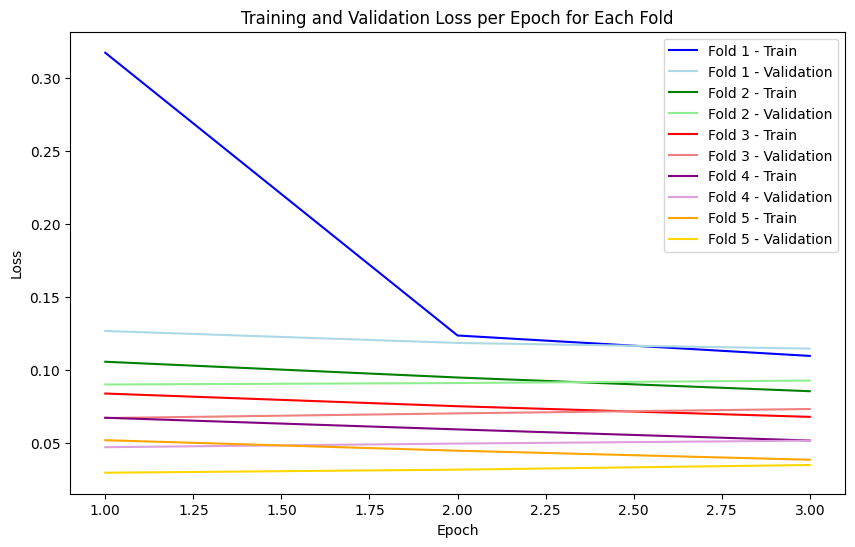

In [21]:
import matplotlib.pyplot as plt

# Data: Each fold's training and validation losses
epochs = [1, 2, 3]

fold_1_train_loss = [0.3175, 0.1236, 0.1096]
fold_1_val_loss = [0.1267, 0.1185, 0.1146]

fold_2_train_loss = [0.1056, 0.0948, 0.0854]
fold_2_val_loss = [0.0900, 0.0910, 0.0927]

fold_3_train_loss = [0.0838, 0.0751, 0.0678]
fold_3_val_loss = [0.0670, 0.0702, 0.0732]

fold_4_train_loss = [0.0672, 0.0592, 0.0516]
fold_4_val_loss = [0.0470, 0.0495, 0.0515]

fold_5_train_loss = [0.0518, 0.0446, 0.0384]
fold_5_val_loss = [0.0295, 0.0316, 0.0348]

# Create the plot
plt.figure(figsize=(10, 6))

# Plotting training and validation losses for each fold
plt.plot(epochs, fold_1_train_loss, label="Fold 1 - Train", color='blue')
plt.plot(epochs, fold_1_val_loss, label="Fold 1 - Validation", color='lightblue')

plt.plot(epochs, fold_2_train_loss, label="Fold 2 - Train", color='green')
plt.plot(epochs, fold_2_val_loss, label="Fold 2 - Validation", color='lightgreen')

plt.plot(epochs, fold_3_train_loss, label="Fold 3 - Train", color='red')
plt.plot(epochs, fold_3_val_loss, label="Fold 3 - Validation", color='lightcoral')

plt.plot(epochs, fold_4_train_loss, label="Fold 4 - Train", color='purple')
plt.plot(epochs, fold_4_val_loss, label="Fold 4 - Validation", color='plum')

plt.plot(epochs, fold_5_train_loss, label="Fold 5 - Train", color='orange')
plt.plot(epochs, fold_5_val_loss, label="Fold 5 - Validation", color='gold')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch for Each Fold')
plt.legend()

# Show the plot
plt.show()

In [ ]:
# Load dataset from Hugging Face
data = load_dataset("", split="train")

In [34]:
# Define custom Dataset class
class FindingsDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        finding = self.data[idx]['findings']
        impression = self.data[idx]['impression']

        inputs = self.tokenizer(finding, max_length=512, truncation=True, padding='max_length', return_tensors="pt")
        targets = self.tokenizer(impression, max_length=256, truncation=True, padding='max_length', return_tensors="pt")

        return {
            'input_ids': inputs['input_ids'].squeeze(0),
            'attention_mask': inputs['attention_mask'].squeeze(0),
            'labels': targets['input_ids'].squeeze(0),
        }

In [ ]:
= FindingsDataset(data, tokenizer)

In [36]:
import torch
from torch.utils.data import random_split

# Set random seed for reproducibility
torch.manual_seed(11)

# Split dataset into train, val, and test
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [37]:
def evaluate_model(model, dataloader):
    model.eval()
    total_loss = 0
    predictions, references = [], []
    with torch.no_grad():
        for batch in dataloader:
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                labels=batch['labels'].to(device)
            )
            loss = outputs.loss
            total_loss += loss.item()

            generated_ids = model.generate(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                max_length=256
            )
            decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            decoded_refs = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)

            # Filter out empty predictions/references
            for pred, ref in zip(decoded_preds, decoded_refs):
                if pred.strip() and ref.strip():
                    predictions.append(pred)
                    references.append([ref])  # Wrap each reference in a list for BLEU

    # Debugging check
    if not predictions or not references:
        print("No valid predictions or references for BLEU/ROUGE evaluation.")
        return total_loss / len(dataloader), {'bleu': 0.0}, {'rougeL': 0.0}

    avg_loss = total_loss / len(dataloader)
    bleu_score = bleu_metric.compute(predictions=predictions, references=references)
    rouge_score = rouge_metric.compute(predictions=predictions, references=references)

    return avg_loss, bleu_score, rouge_score

In [43]:
!pip install rouge_score bleu evaluate -q
# Initialize metrics
bleu_metric = load('bleu')
rouge_metric = load('rouge')

In [44]:
# Final evaluation on validation and test sets
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

val_loss, val_bleu, val_rouge = evaluate_model(model, val_loader)
test_loss, test_bleu, test_rouge = evaluate_model(model, test_loader)

In [45]:
# Print overall scores
print("Validation Set BLEU Score:", val_bleu)
print("Validation Set ROUGE Scores:", val_rouge)
print("Test Set BLEU Score:", test_bleu)
print("Test Set ROUGE Scores:", test_rouge)

Validation Set BLEU Score: {'bleu': 0.5863207135476154, 'precisions': [0.8085954972416878, 0.7065064501868745, 0.6479640770773389, 0.6003905133822269], 'brevity_penalty': 0.8539396656235351, 'length_ratio': 0.8636363636363636, 'translation_length': 26828, 'reference_length': 31064}
Validation Set ROUGE Scores: {'rouge1': 0.7460234969146675, 'rouge2': 0.6605070588539618, 'rougeL': 0.7321113624919615, 'rougeLsum': 0.7320716912763621}
Test Set BLEU Score: {'bleu': 0.5655706395406904, 'precisions': [0.8102007312887098, 0.706107177341487, 0.645017677098337, 0.5940107767869915], 'brevity_penalty': 0.8265698433063325, 'length_ratio': 0.8400037609302035, 'translation_length': 26802, 'reference_length': 31907}
Test Set ROUGE Scores: {'rouge1': 0.7500840864072538, 'rouge2': 0.6680097060315715, 'rougeL': 0.7368223367255375, 'rougeLsum': 0.7368901955427365}


In [46]:
train_loader = DataLoader(train_dataset, batch_size=16)
train_loss, train_bleu, train_rouge = evaluate_model(model, train_loader)

In [47]:
# Print overall scores
print("Train Set Loss:", train_loss)
print("Train Set BLEU Score:", train_bleu)
print("Train Set ROUGE Scores:", train_rouge)

Train Set Loss: 0.020632544025120242
Train Set BLEU Score: {'bleu': 0.5708403507054974, 'precisions': [0.8043148076352938, 0.6996376740441076, 0.639512446643951, 0.5890845886442642], 'brevity_penalty': 0.8412657067846538, 'length_ratio': 0.8526256022960166, 'translation_length': 219245, 'reference_length': 257141}
Train Set ROUGE Scores: {'rouge1': 0.7461997961271825, 'rouge2': 0.6616972295167777, 'rougeL': 0.7324121939644432, 'rougeLsum': 0.7322773267835072}


In [53]:
# Scatter and histogram plot of BLEU scores for test set instances
def plot_bleu_scatter_histogram(test_loader, model):
    max_length=256
    model.eval()
    bleu_scores = []
    predictions, references = [], []

    with torch.no_grad():
        for batch in test_loader:
            generated_ids = model.generate(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                max_length=max_length
            )
            decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            decoded_refs = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)

            predictions.extend(decoded_preds)
            references.extend([[ref] for ref in decoded_refs])

    for pred, ref in zip(predictions, references):
        score = bleu_metric.compute(predictions=[pred], references=[ref])['bleu']
        bleu_scores.append(score)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(range(len(bleu_scores)), bleu_scores, alpha=0.6)
    plt.title("BLEU Scores Scatter Plot")
    plt.xlabel("Test Instance")
    plt.ylabel("BLEU Score")

    plt.subplot(1, 2, 2)
    plt.hist(bleu_scores, bins=20, alpha=0.7)
    plt.title("BLEU Scores Histogram")
    plt.xlabel("BLEU Score")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

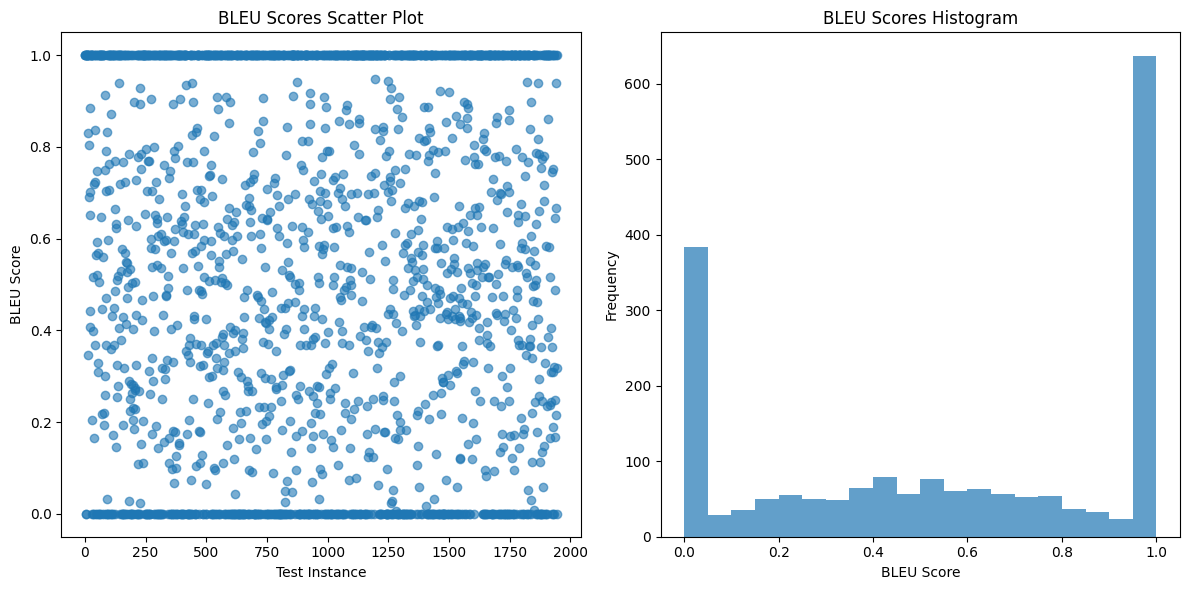

In [54]:
plot_bleu_scatter_histogram(test_loader, model)

In [70]:
def compare_impression_with_metrics(model, tokenizer, dataset, index, max_input_length=512, max_output_length=256, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Compare the actual and generated impression for a given dataset example by index, including BLEU and ROUGE scores.

    Args:
        model: Trained model (e.g., BART model).
        tokenizer: Tokenizer corresponding to the model.
        dataset: Dataset object containing 'findings' and 'impression' fields.
        index: Index of the example in the dataset.
        max_input_length: Maximum length of input sequence.
        max_output_length: Maximum length of output sequence.
        device: Device to perform inference on (CPU or GPU).

    Returns:
        dict: A dictionary containing findings, actual impression, generated impression, BLEU score, and ROUGE scores.
    """
    model.eval()
    model.to(device)

    # Extract the findings and actual impression from the dataset
    example = dataset[index]
    findings = example['findings']
    actual_impression = example['impression']

    # Tokenize findings
    inputs = tokenizer(
        findings,
        max_length=max_input_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    ).to(device)

    # Generate impression
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=max_output_length,
            num_beams=5,
            early_stopping=True
        )

    # Decode the output
    generated_impression = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # Calculate BLEU and ROUGE scores
    bleu_score = bleu_metric.compute(predictions=[generated_impression], references=[[actual_impression]])
    rouge_scores = rouge_metric.compute(predictions=[generated_impression], references=[actual_impression])

    # Print results
    print("Findings:")
    print(findings)
    print("\nActual Impression:")
    print(actual_impression)
    print("\nGenerated Impression:")
    print(generated_impression)
    print("\nMetrics:")
    print(f"BLEU Score: {bleu_score['bleu']:.4f}")
    print("ROUGE Scores:")
    print(f"  ROUGE-1: {rouge_scores['rouge1']:.4f}")
    print(f"  ROUGE-2: {rouge_scores['rouge2']:.4f}")
    print(f"  ROUGE-L: {rouge_scores['rougeL']:.4f}")

    # Return results as a dictionary
    return {
        "findings": findings,
        "actual_impression": actual_impression,
        "generated_impression": generated_impression,
        "bleu_score": bleu_score,
        "rouge_scores": {
            "ROUGE-1": rouge_scores["rouge1"],
            "ROUGE-2": rouge_scores["rouge2"],
            "ROUGE-L": rouge_scores["rougeL"],
        }
    }

# Example Usage
# Index from the training dataset
index = 300  # Replace with any valid index
comparison_result = compare_impression_with_metrics(model, tokenizer, data, index)

Findings:
A tracheostomy tube is present. Mild pulmonary edema is again noted. There are small layering pleural effusions as well as bibasilar opacities reflecting atelectasis and/or consolidation. No pneumothorax identified. The size of the cardiac silhouette is at the upper limits of normal. 

Actual Impression:
Mild pulmonary edema. Small bilateral pleural effusions with overlying opacities likely reflecting atelectasis and/or consolidation.

Generated Impression:
Mild pulmonary edema and small bilateral pleural effusions. Bibasilar opacities may reflect atelectasis and/or consolidation.

Metrics:
BLEU Score: 0.3952
ROUGE Scores:
  ROUGE-1: 0.7500
  ROUGE-2: 0.5333
  ROUGE-L: 0.7500


In [10]:
# Save the trained model
model.save_pretrained("./bart_impression_model")
tokenizer.save_pretrained("./bart_impression_model")

/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:2817: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


('./bart_impression_model/tokenizer_config.json',
 './bart_impression_model/special_tokens_map.json',
 './bart_impression_model/vocab.json',
 './bart_impression_model/merges.txt',
 './bart_impression_model/added_tokens.json')

In [ ]:
import shutil

import os

from IPython.display import FileLink

# Define the directory to zip

model_dir = "/kaggle/working/bart_impression_model"

zip_file_path = "./impression-model-bart.zip"



# Create a zip file of the model directory

shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', model_dir)



# Now, you can use the appropriate method to download the zip file.

# If you're in a Jupyter Notebook, you can use the following code to create a download link:


# Create a download link for the zip file

FileLink(zip_file_path)

In [55]:
# Scatter and histogram plot of BLEU scores for test set instances
def plot_bleu_scatter_histogram(val_loader, model):
    max_length=256
    model.eval()
    bleu_scores = []
    predictions, references = [], []

    with torch.no_grad():
        for batch in val_loader:
            generated_ids = model.generate(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device),
                max_length=max_length
            )
            decoded_preds = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            decoded_refs = tokenizer.batch_decode(batch['labels'], skip_special_tokens=True)

            predictions.extend(decoded_preds)
            references.extend([[ref] for ref in decoded_refs])

    for pred, ref in zip(predictions, references):
        score = bleu_metric.compute(predictions=[pred], references=[ref])['bleu']
        bleu_scores.append(score)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(range(len(bleu_scores)), bleu_scores, alpha=0.6)
    plt.title("BLEU Scores Scatter Plot")
    plt.xlabel("Validation Instance")
    plt.ylabel("BLEU Score")

    plt.subplot(1, 2, 2)
    plt.hist(bleu_scores, bins=20, alpha=0.7)
    plt.title("BLEU Scores Histogram")
    plt.xlabel("BLEU Score")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

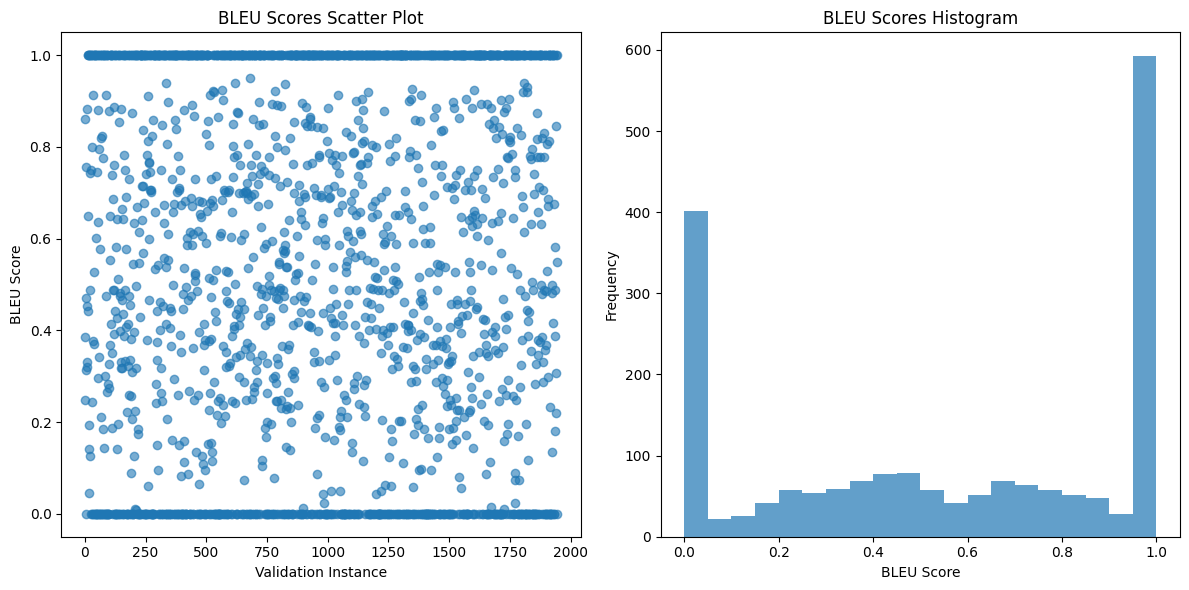

In [56]:
plot_bleu_scatter_histogram(val_loader, model)

In [18]:
def generate_impression(model, tokenizer, findings, max_input_length=512, max_output_length=256, device="cuda" if torch.cuda.is_available() else "cpu"):
    """
    Generate impression for the given findings using the trained model.
    
    Args:
        model: Trained model (e.g., BART model).
        tokenizer: Tokenizer corresponding to the model.
        findings: String containing the findings to generate impressions for.
        max_input_length: Maximum length of input sequence.
        max_output_length: Maximum length of output sequence.
        device: Device to perform inference on (CPU or GPU).

    Returns:
        String: Generated impression.
    """
    model.eval()
    model.to(device)

    # Tokenize input findings
    inputs = tokenizer(
        findings,
        max_length=max_input_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt"
    ).to(device)

    # Generate output
    with torch.no_grad():
        outputs = model.generate(
            input_ids=inputs['input_ids'],
            attention_mask=inputs['attention_mask'],
            max_length=max_output_length,
            num_beams=5,  # Beam search for better results
            early_stopping=True
        )

    # Decode the output to get the generated impression
    impression = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return impression

# Example Usage
# Load the saved model and tokenizer
from transformers import BartTokenizer, BartForConditionalGeneration

model_path = "/kaggle/working/bart_impression_model"
tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path)

# Input findings (example)
new_findings = "The heart size is mildly enlarged. The aortic knob is calcified. There is mild pulmonary edema. Small bilateral pleural effusions are present. There is no pneumothorax. Small amount of subdiaphragmatic free air is present."

# Generate impression
generated_impression = generate_impression(model, tokenizer, new_findings)
print("Findings:")
print(new_findings)
print("\nGenerated Impression:")
print(generated_impression)

Findings:
The heart size is mildly enlarged. The aortic knob is calcified. There is mild pulmonary edema. Small bilateral pleural effusions are present. There is no pneumothorax. Small amount of subdiaphragmatic free air is present.

Generated Impression:
Mild pulmonary edema and small bilateral pleural effusions.
